In [77]:
import torch  # Main torch import for torch tensors
import torch.nn as nn  # Neural network module for building deep learning models
import torch.nn.functional as F  # Functional module, includes activation functions
import torch.optim as optim  # Optimization module
import torchvision  # Vision / image processing package built on top of torch
import typing
from torch.utils.data import DataLoader

from matplotlib import pyplot as plt  # Plotting and visualization
from sklearn.metrics import accuracy_score  # Computing accuracy metric

In [78]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

'cpu'

In [ ]:
def load_data() -> typing.Tuple[DataLoader, DataLoader]:
    train_transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=0.1307, std=0.3081)
    ])

    test_transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=0.1307, std=0.3081)
    ])

    # Download the MNIST data and apply the transformation pipeline
    train_data = torchvision.datasets.MNIST('./datafiles/', train=True, download=True, transform=train_transform)
    test_data = torchvision.datasets.MNIST('./datafiles/', train=False, download=True, transform=test_transform)

    # Setup data loaders
    # Note: Iterating through the dataloader yields batches of (inputs, targets)
    # where inputs is a torch.Tensor of shape (B, 1, 28, 28) and targets is a torch.Tensor of shape (B,)
    BATCH_SIZE = 512
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=1000)
    return train_loader, test_loader

def visualize_batch(data_loader: DataLoader) -> None:
    # Plot examples of transformations
    fig, axs = plt.subplots(4, 5, figsize=(5, 6))

    plot_images = []
    plot_labels = []

    for images, labels in data_loader:
        for i in range(images.shape[0]):
            plot_images.append(images[i])
            plot_labels.append(labels[i])
            if len(plot_images) >= 20:
                break
        if len(plot_images) >= 20:
            break

    for i in range(4):
        for j in range(5):
            axs[i, j].imshow(plot_images[i * 5 + j].squeeze(), cmap='gray')
            axs[i, j].set_title(f"Label: {plot_labels[i * 5 + j].item()}")
            axs[i, j].axis('off')

    plt.tight_layout()
    plt.show()
    plt.close()
    return

def train(model, train_loader, loss_fn, optimizer, epoch=-1):
    """
    Trains a model for one epoch (one pass through the entire training data).

    :param model: PyTorch model
    :param train_loader: PyTorch Dataloader for training data
    :param loss_fn: PyTorch loss function
    :param optimizer: PyTorch optimizer, initialized with model parameters
    :kwarg epoch: Integer epoch to use when printing loss and accuracy
    :returns: Accuracy score
    """
    total_loss = 0
    all_predictions = []
    all_targets = []
    loss_history = []

    model = model.to(DEVICE)
    model.train()  # Set model in training mode

    for i, (inputs, targets) in enumerate(train_loader):
        optimizer.zero_grad()
        inputs = inputs.to(DEVICE)
        outputs = model(inputs)
        loss = loss_fn(outputs, targets.to(DEVICE))
        loss.backward()
        optimizer.step()

        # Track some values to compute statistics
        total_loss += loss.item()
        preds = torch.argmax(outputs, dim=-1)
        all_predictions.extend(preds.detach().cpu().tolist())
        all_targets.extend(targets.cpu().tolist())

        # Save loss every 100 batches
        if (i % 100 == 0) and (i > 0):
            running_loss = total_loss / (i + 1)
            loss_history.append(running_loss)
            # print(f"Epoch {epoch + 1}, batch {i + 1}: loss = {running_loss:.2f}")

    acc = accuracy_score(all_targets, all_predictions)
    final_loss = total_loss / len(train_loader)
    # Print average loss and accuracy
    print(f"Epoch {epoch + 1} done. Average train loss = {final_loss:.2f}, average train accuracy = {acc * 100:.3f}%")
    return acc, final_loss

def test(model, test_loader, loss_fn, epoch=-1):
    """
    Tests a model for one epoch of test data.

    Note:
        In testing and evaluation, we do not perform gradient descent optimization, so steps 2, 5, and 6 are not needed.
        For performance, we also tell torch not to track gradients by using the `with torch.no_grad()` context.

    :param model: PyTorch model
    :param test_loader: PyTorch Dataloader for test data
    :param loss_fn: PyTorch loss function
    :kwarg epoch: Integer epoch to use when printing loss and accuracy

    :returns: Accuracy score
    """
    total_loss = 0
    all_predictions = []
    all_targets = []

    model = model.to(DEVICE)
    model.eval()  # Set model in evaluation mode
    for i, (inputs, targets) in enumerate(test_loader):
        with torch.no_grad():
            outputs = model(inputs.to(DEVICE))
            loss = loss_fn(outputs, targets.to(DEVICE))

            # Track some values to compute statistics
            total_loss += loss.item()
            preds = torch.argmax(outputs, dim=-1)
            all_predictions.extend(preds.detach().cpu().tolist())
            all_targets.extend(targets.cpu().tolist())

    acc = accuracy_score(all_targets, all_predictions)
    final_loss = total_loss / len(test_loader)
    # Print average loss and accuracy
    print(f"Epoch {epoch + 1} done. Average test loss = {final_loss:.2f}, average test accuracy = {acc * 100:.3f}%")
    return acc, final_loss

train_loader, test_loader = load_data()

In [80]:
def training_loop(model, loss_fn, optimizer, num_epochs=10, learning_rate=0.001, show_plots=True):
    train_accuracies = []
    test_accuracies = []
    train_losses = []
    test_losses = []

    for epoch in range(num_epochs):
        train_acc, train_loss = train(model, train_loader, loss_fn, optimizer, epoch)
        test_acc, test_loss = test(model, test_loader, loss_fn, epoch)

        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)
        train_losses.append(train_loss)
        test_losses.append(test_loss)

    if not show_plots:
        return train_accuracies, test_accuracies, train_losses, test_losses

    # Plot accuracies
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    axs[0].plot(range(1, num_epochs + 1), train_accuracies, label="Train Accuracy")
    axs[0].plot(range(1, num_epochs + 1), test_accuracies, label="Test Accuracy")
    axs[0].set_title("Accuracy over Epochs")
    axs[0].set_xlabel("Epochs")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend()

    # Plot losses
    axs[1].plot(range(1, num_epochs + 1), train_losses, label="Train Loss")
    axs[1].plot(range(1, num_epochs + 1), test_losses, label="Test Loss")
    axs[1].set_title("Loss over Epochs")
    axs[1].set_ylabel("Loss")
    axs[1].legend()

    plt.show()
    plt.close()
    return train_accuracies, test_accuracies, train_losses, test_losses

# Baseline CNN Architecture
One convolutional layer with 16 out-channels and one fully connected layer with 10 outputs.

Epoch 1 done. Average train loss = 0.39, average train accuracy = 88.207%
Epoch 1 done. Average test loss = 0.18, average test accuracy = 94.970%
Epoch 2 done. Average train loss = 0.14, average train accuracy = 96.095%
Epoch 2 done. Average test loss = 0.11, average test accuracy = 96.760%
Epoch 3 done. Average train loss = 0.09, average train accuracy = 97.345%
Epoch 3 done. Average test loss = 0.10, average test accuracy = 97.310%
Epoch 4 done. Average train loss = 0.07, average train accuracy = 97.943%
Epoch 4 done. Average test loss = 0.08, average test accuracy = 97.490%
Epoch 5 done. Average train loss = 0.06, average train accuracy = 98.327%
Epoch 5 done. Average test loss = 0.08, average test accuracy = 97.500%
Epoch 6 done. Average train loss = 0.05, average train accuracy = 98.603%
Epoch 6 done. Average test loss = 0.07, average test accuracy = 97.670%
Epoch 7 done. Average train loss = 0.04, average train accuracy = 98.758%
Epoch 7 done. Average test loss = 0.07, average te

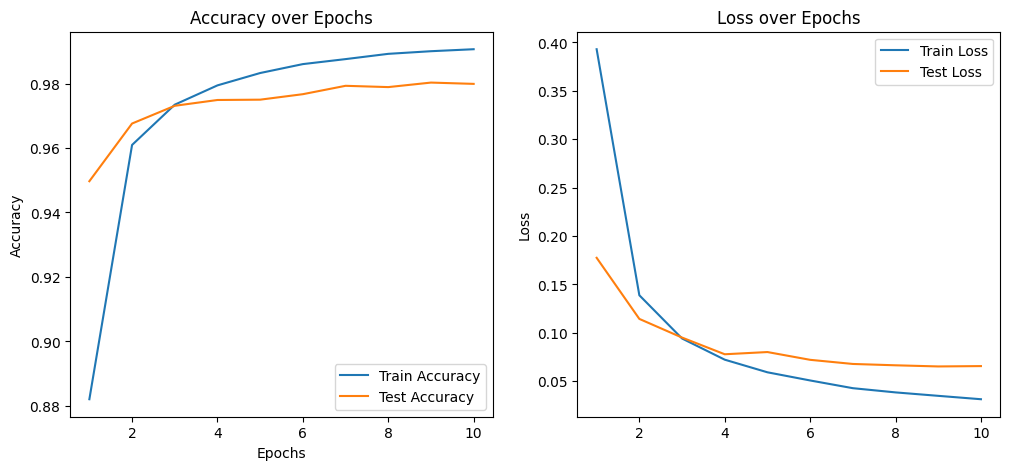

([0.8820666666666667,
  0.96095,
  0.97345,
  0.9794333333333334,
  0.9832666666666666,
  0.9860333333333333,
  0.9875833333333334,
  0.9892166666666666,
  0.9900333333333333,
  0.99065],
 [0.9497,
  0.9676,
  0.9731,
  0.9749,
  0.975,
  0.9767,
  0.9793,
  0.9789,
  0.9803,
  0.9799],
 [0.3929677169959424,
  0.13886595706818466,
  0.09421780121402215,
  0.07232780754566193,
  0.059298231155943064,
  0.05086865288726354,
  0.042889240229407606,
  0.038537393410895335,
  0.034986747302493806,
  0.031490905565541176],
 [0.1775491178035736,
  0.114441192522645,
  0.09516510143876075,
  0.07792583610862494,
  0.08021338023245335,
  0.07218273729085922,
  0.06791304424405098,
  0.06652820883318782,
  0.06534369699656964,
  0.06571024181321264])

In [81]:
class BaselineConvNet(nn.Module):
    def __init__(self):
        super().__init__()

        # Convolutional layers with stride for downsampling
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)

        # Fully connected layers
        dim = 28 * 28 * 16
        self.fc1 = nn.Linear(28 * 28 * 16, 10)

    def forward(self, x):
        # First conv block
        x = F.relu(self.conv1(x))   # (batch, 16, 28, 28)

        # Flatten
        x = x.view(x.size(0), -1)   # (batch, 1568)

        # Fully connected layers
        x = self.fc1(x)

        return x

model = BaselineConvNet()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
training_loop(model=model, loss_fn=loss_fn, optimizer=optimizer, num_epochs=10, learning_rate=0.001, show_plots=True)

# Optimization Parameters Experimentation
- Learning Rate
- Batch Size

### Learning Rate


Testing learning rate = 1e-05
Epoch 1 done. Average train loss = 2.09, average train accuracy = 49.840%
Epoch 1 done. Average test loss = 1.87, average test accuracy = 71.850%
Epoch 2 done. Average train loss = 1.69, average train accuracy = 75.992%
Epoch 2 done. Average test loss = 1.50, average test accuracy = 81.110%
Epoch 3 done. Average train loss = 1.37, average train accuracy = 81.115%
Epoch 3 done. Average test loss = 1.22, average test accuracy = 83.340%
Epoch 4 done. Average train loss = 1.13, average train accuracy = 83.122%
Epoch 4 done. Average test loss = 1.02, average test accuracy = 85.210%
Epoch 5 done. Average train loss = 0.96, average train accuracy = 84.643%
Epoch 5 done. Average test loss = 0.87, average test accuracy = 86.400%
Learning rate: 1e-05, Final Test Accuracy: 86.40%

Testing learning rate = 0.001
Epoch 1 done. Average train loss = 0.41, average train accuracy = 87.907%
Epoch 1 done. Average test loss = 0.19, average test accuracy = 95.000%
Epoch 2 done

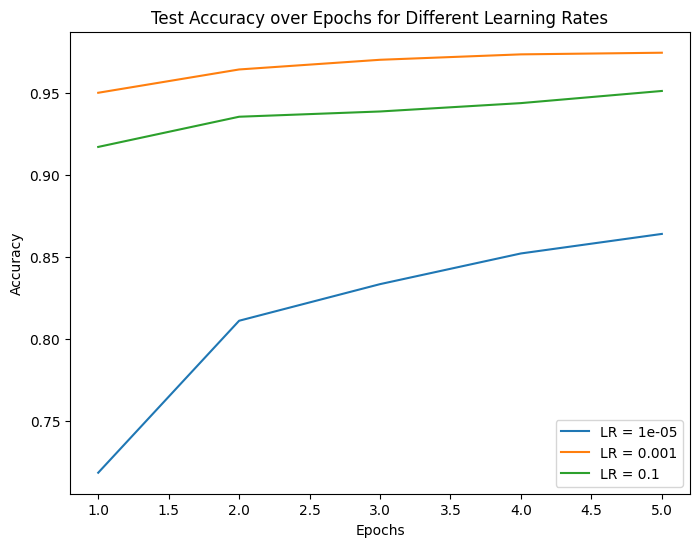

In [82]:
learning_rates = [1e-5, 1e-3, 1e-1]
all_test_accs = []

for lr in learning_rates:
    print(f"\nTesting learning rate = {lr}")

    # Re-initialize model
    model = BaselineConvNet()

    # Define optimizer and loss
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()

    # Train and evaluate
    train_accs, test_accs, train_losses, test_losses = training_loop(
        model, loss_fn, optimizer, num_epochs=5, learning_rate=lr, show_plots=False
    )

    all_test_accs.append(test_accs)  # store for plotting
    final_test_acc = test_accs[-1]
    print(f"Learning rate: {lr}, Final Test Accuracy: {final_test_acc*100:.2f}%")

# Plot results
plt.figure(figsize=(8, 6))
for i, lr in enumerate(learning_rates):
    plt.plot(range(1, len(all_test_accs[i]) + 1), all_test_accs[i], label=f"LR = {lr}")
plt.title("Test Accuracy over Epochs for Different Learning Rates")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

### Batch Size


Testing batch size = 64
Epoch 1 done. Average train loss = 0.20, average train accuracy = 94.203%
Epoch 1 done. Average test loss = 0.10, average test accuracy = 97.130%
Epoch 2 done. Average train loss = 0.08, average train accuracy = 97.718%
Epoch 2 done. Average test loss = 0.08, average test accuracy = 97.430%
Epoch 3 done. Average train loss = 0.05, average train accuracy = 98.375%
Epoch 3 done. Average test loss = 0.07, average test accuracy = 97.850%
Epoch 4 done. Average train loss = 0.04, average train accuracy = 98.748%
Epoch 4 done. Average test loss = 0.08, average test accuracy = 97.830%
Epoch 5 done. Average train loss = 0.03, average train accuracy = 98.988%
Epoch 5 done. Average test loss = 0.07, average test accuracy = 97.650%
Batch size: 64, Final Test Accuracy: 97.65%

Testing batch size = 128
Epoch 1 done. Average train loss = 0.25, average train accuracy = 92.517%
Epoch 1 done. Average test loss = 0.13, average test accuracy = 96.080%
Epoch 2 done. Average train l

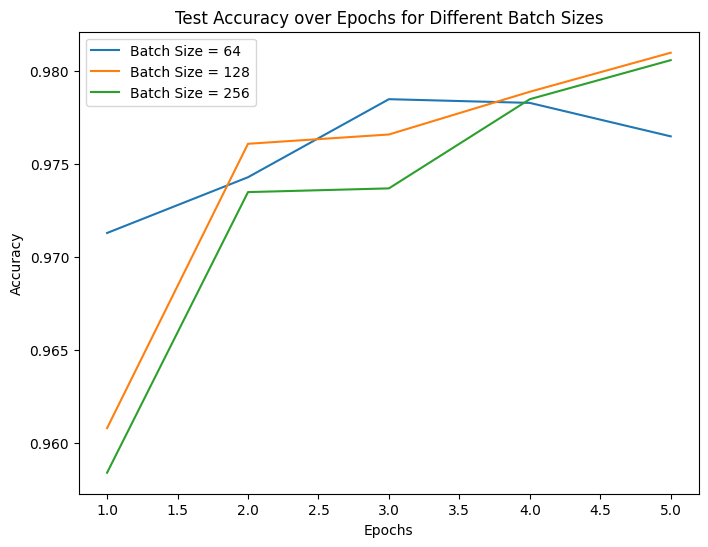

In [83]:
batch_sizes = [64, 128, 256]
all_test_accs = []

# Any data augmentation should be added to training
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=0.1307, std=0.3081)
])

# Test data should have normalization applied, but no augmentation
test_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=0.1307, std=0.3081)
])

# Download the MNIST data and lazily apply the transformation pipeline
train_data = torchvision.datasets.MNIST('./datafiles/', train=True, download=True, transform=train_transform)
test_data = torchvision.datasets.MNIST('./datafiles/', train=False, download=True, transform=test_transform)

for bs in batch_sizes:
    print(f"\nTesting batch size = {bs}")

    # Create new loaders
    train_loader = DataLoader(train_data, batch_size=bs, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=bs, shuffle=False)

    # Re-initialize model and optimizer
    model = BaselineConvNet()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    loss_fn = nn.CrossEntropyLoss()

    # Train and evaluate
    train_accs, test_accs, train_losses, test_losses = training_loop(
        model, loss_fn, optimizer, num_epochs=5, learning_rate=0.001, show_plots=False
    )

    all_test_accs.append(test_accs)
    final_test_acc = test_accs[-1]
    print(f"Batch size: {bs}, Final Test Accuracy: {final_test_acc*100:.2f}%")

# --- Plot results ---
plt.figure(figsize=(8, 6))
for i, bs in enumerate(batch_sizes):
    plt.plot(range(1, len(all_test_accs[i]) + 1), all_test_accs[i], label=f"Batch Size = {bs}")
plt.title("Test Accuracy over Epochs for Different Batch Sizes")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Architecture Experimentation
- Number of Fully Connected Layers
- Number of Convolution Layers
- Number of Out-Channels (Kernels)
- Pooling, Stride, Padding
- Kernel Size


### Number of Fully Connected Layers
Experimented with 1 convolutional layer with 2 to 3 fully connected layers.


Training model: 2 FC Layers

Epoch 1 done. Average train loss = 0.31, average train accuracy = 90.755%
Epoch 1 done. Average test loss = 0.14, average test accuracy = 95.960%
Epoch 2 done. Average train loss = 0.11, average train accuracy = 96.927%
Epoch 2 done. Average test loss = 0.08, average test accuracy = 97.400%
Epoch 3 done. Average train loss = 0.07, average train accuracy = 97.957%
Epoch 3 done. Average test loss = 0.08, average test accuracy = 97.580%
Epoch 4 done. Average train loss = 0.05, average train accuracy = 98.522%
Epoch 4 done. Average test loss = 0.05, average test accuracy = 98.190%
Epoch 5 done. Average train loss = 0.03, average train accuracy = 98.992%
Epoch 5 done. Average test loss = 0.06, average test accuracy = 98.030%

Training model: 3 FC Layers

Epoch 1 done. Average train loss = 0.25, average train accuracy = 92.280%
Epoch 1 done. Average test loss = 0.09, average test accuracy = 97.090%
Epoch 2 done. Average train loss = 0.07, average train accuracy 

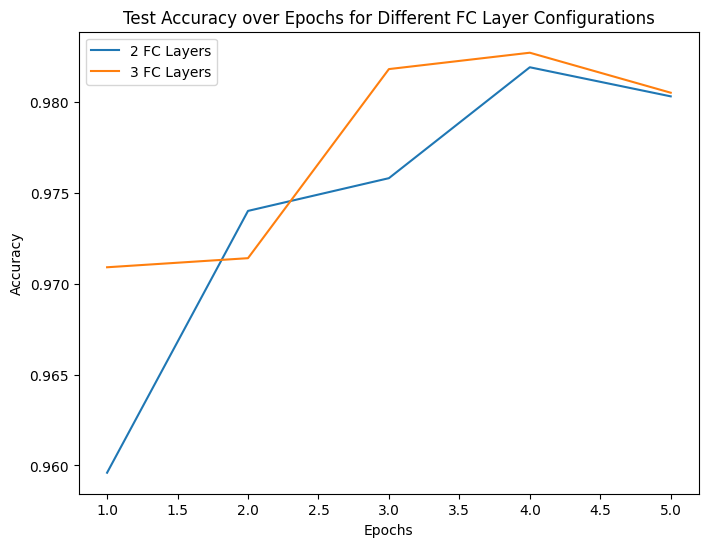

In [84]:
# --- 2 FC layers ---
class FC2ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(28 * 28 * 16, 128)  # hidden layer
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


# --- 3 FC layers ---
class FC3ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(28 * 28 * 16, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

NUM_EPOCHS = 5

# Store metrics for plotting
training_accuracies, test_accuracies, train_losses, test_losses = [], [], [], []

# Test 2 and 3 fully connected layers
models = {
    "2 FC Layers": FC2ConvNet(),
    "3 FC Layers": FC3ConvNet()
}

# Train each model
for name, model in models.items():
    print(f"\nTraining model: {name}\n")
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    loss_fn = nn.CrossEntropyLoss()

    train_accs, test_accs, train_losses_i, test_losses_i = training_loop(model=model, loss_fn=loss_fn, optimizer=optimizer, num_epochs=NUM_EPOCHS, learning_rate=0.001, show_plots=False)

    training_accuracies.append(train_accs)
    test_accuracies.append(test_accs)
    train_losses.append(train_losses_i)
    test_losses.append(test_losses_i)

# Plot test accuracy for each model
fig, axs = plt.subplots(1, 1, figsize=(8, 6))
for i, name in enumerate(models.keys()):
    axs.plot(range(1, NUM_EPOCHS + 1), test_accuracies[i], label=name)

axs.set_title("Test Accuracy over Epochs for Different FC Layer Configurations")
axs.set_xlabel("Epochs")
axs.set_ylabel("Accuracy")
axs.legend()
plt.show()

### Number of Convolutional Layers
Experimented with 1 to 4 layers of convolutional layers with 1 fully connected layer.

In [85]:
class Variable_Convolution_Layers_CNN(nn.Module):
  def __init__(self, num_layers=1):
      super().__init__()
      # Convolutional layers with stride for downsampling
      self.num_layers = num_layers
      self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
      self.conv2 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
      self.conv3 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
      self.conv4 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
      self.conv_layers = [self.conv1, self.conv2, self.conv3, self.conv4]
      # Fully connected layers dimension based on num_layers
      dimension = 28 * 28 * 16
      print("Dimension: ", dimension)
      self.fc1 = nn.Linear(dimension, 10)

  def forward(self, x):
      for i in range(0, self.num_layers):
          x = F.relu(self.conv_layers[i](x))

      # Flatten
      x = x.view(x.size(0), -1)   # (batch, 1568)

      # Fully connected layers
      x = self.fc1(x)

      return x


Training CNN with 1 convolutional layers:

Dimension:  12544
Epoch 1 done. Average train loss = 0.26, average train accuracy = 92.167%
Epoch 1 done. Average test loss = 0.12, average test accuracy = 96.750%
Epoch 2 done. Average train loss = 0.10, average train accuracy = 97.253%
Epoch 2 done. Average test loss = 0.08, average test accuracy = 97.540%
Epoch 3 done. Average train loss = 0.07, average train accuracy = 98.050%
Epoch 3 done. Average test loss = 0.07, average test accuracy = 97.900%
Epoch 4 done. Average train loss = 0.05, average train accuracy = 98.467%
Epoch 4 done. Average test loss = 0.07, average test accuracy = 97.970%
Epoch 5 done. Average train loss = 0.04, average train accuracy = 98.748%
Epoch 5 done. Average test loss = 0.07, average test accuracy = 97.870%

Training CNN with 2 convolutional layers:

Dimension:  12544
Epoch 1 done. Average train loss = 0.26, average train accuracy = 92.455%
Epoch 1 done. Average test loss = 0.08, average test accuracy = 97.650%


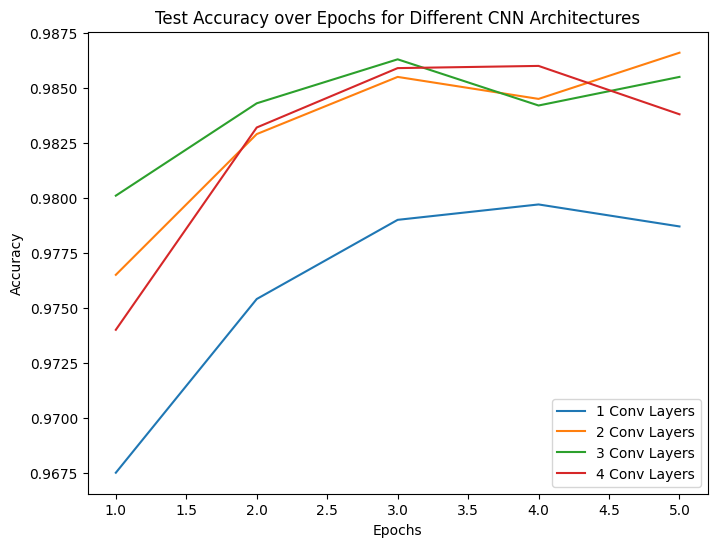

In [86]:
NUM_EPOCHS = 5
MAX_LAYERS = 4
training_accuracies, test_accuracies, train_losses, test_losses = [], [], [], []

for i in range(1, MAX_LAYERS + 1):
    print(f"\nTraining CNN with {i} convolutional layers:\n")
    cnn = Variable_Convolution_Layers_CNN(num_layers=i)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(cnn.parameters(), lr=0.001)
    training_accuracies_i, test_accuracies_i, train_losses_i, test_losses_i = training_loop(model=cnn, loss_fn=loss_fn, optimizer=optimizer, num_epochs=NUM_EPOCHS, learning_rate=0.001, show_plots=False)
    # exit(0)
    training_accuracies.append(training_accuracies_i)
    test_accuracies.append(test_accuracies_i)
    train_losses.append(train_losses_i)
    test_losses.append(test_losses_i)

# Plotting all test accuracies 1 plot
fig, axs = plt.subplots(1, 1, figsize=(8, 6))
for i in range(MAX_LAYERS):
    axs.plot(range(1, NUM_EPOCHS + 1), test_accuracies[i], label=f"{i + 1} Conv Layers")
axs.set_title("Test Accuracy over Epochs for Different CNN Architectures")
axs.set_xlabel("Epochs")
axs.set_ylabel("Accuracy")
axs.legend()

In [87]:
class Variable_Number_Channels_CNN(nn.Module):
    def __init__(self, num_channels=16):
        super().__init__()
        # Convolutional layers with stride for downsampling
        self.conv1 = nn.Conv2d(1, num_channels, kernel_size=3, padding=1)

        # Fully connected layers dimension based on num_layers
        dimension = 28 * 28 * num_channels
        print("Dimension: ", dimension)
        self.fc1 = nn.Linear(dimension, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))

        # Flatten
        x = x.view(x.size(0), -1)   # (batch, 1568)

        # Fully connected layers
        x = self.fc1(x)

        return x


Training CNN with 8 channels in first convolutional layer:

Dimension:  6272
Epoch 1 done. Average train loss = 0.33, average train accuracy = 90.932%
Epoch 1 done. Average test loss = 0.16, average test accuracy = 95.540%
Epoch 2 done. Average train loss = 0.13, average train accuracy = 96.300%
Epoch 2 done. Average test loss = 0.10, average test accuracy = 97.040%
Epoch 3 done. Average train loss = 0.09, average train accuracy = 97.437%
Epoch 3 done. Average test loss = 0.08, average test accuracy = 97.480%
Epoch 4 done. Average train loss = 0.07, average train accuracy = 97.938%
Epoch 4 done. Average test loss = 0.07, average test accuracy = 97.620%
Epoch 5 done. Average train loss = 0.06, average train accuracy = 98.258%
Epoch 5 done. Average test loss = 0.07, average test accuracy = 97.770%

Training CNN with 16 channels in first convolutional layer:

Dimension:  12544
Epoch 1 done. Average train loss = 0.29, average train accuracy = 91.423%
Epoch 1 done. Average test loss = 0.13

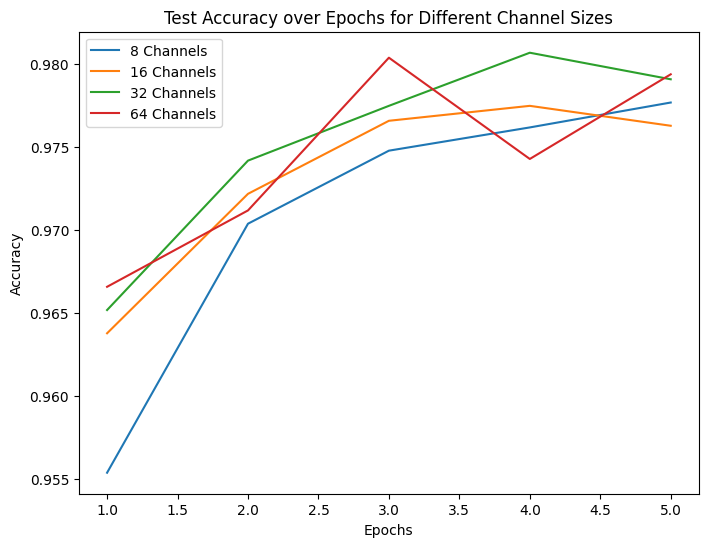

In [88]:
NUM_EPOCHS = 5
CHANNEL_OPTIONS = [8, 16, 32, 64]

training_accuracies, test_accuracies, train_losses, test_losses = [], [], [], []

for channels in CHANNEL_OPTIONS:
    print(f"\nTraining CNN with {channels} channels in first convolutional layer:\n")
    cnn = Variable_Number_Channels_CNN(num_channels=channels)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(cnn.parameters(), lr=0.001)
    training_accuracies_i, test_accuracies_i, train_losses_i, test_losses_i = training_loop(model=cnn, loss_fn=loss_fn, optimizer=optimizer, num_epochs=NUM_EPOCHS, learning_rate=0.001, show_plots=False)
    training_accuracies.append(training_accuracies_i)
    test_accuracies.append(test_accuracies_i)
    train_losses.append(train_losses_i)
    test_losses.append(test_losses_i)

# Plotting one accuracy plot
fig, axs = plt.subplots(1, 1, figsize=(8, 6))
for i in range(len(CHANNEL_OPTIONS)):
    axs.plot(range(1, NUM_EPOCHS + 1), test_accuracies[i], label=f"{CHANNEL_OPTIONS[i]} Channels")
axs.set_title("Test Accuracy over Epochs for Different Channel Sizes")
axs.set_xlabel("Epochs")
axs.set_ylabel("Accuracy")
axs.legend()


### Pooling

In [89]:
class PoolingCNN(nn.Module):
    def __init__(self, pooling_type='max'):
        super().__init__()
        # Convolutional layers with stride for downsampling
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.pooling_type = pooling_type
        self.pool = nn.MaxPool2d(2, 2) if pooling_type == 'max' else nn.AvgPool2d(2, 2)
        # Fully connected layers dimension based on num_layers
        dimension = 14 * 14 * 16
        print("Dimension: ", dimension)
        self.fc1 = nn.Linear(dimension, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)

        # Flatten
        x = x.view(x.size(0), -1)   # (batch, 1568)

        # Fully connected layers
        x = self.fc1(x)

        return x


Training CNN with max pooling:

Dimension:  3136
Epoch 1 done. Average train loss = 0.36, average train accuracy = 89.878%
Epoch 1 done. Average test loss = 0.17, average test accuracy = 95.320%
Epoch 2 done. Average train loss = 0.14, average train accuracy = 96.155%
Epoch 2 done. Average test loss = 0.11, average test accuracy = 97.000%
Epoch 3 done. Average train loss = 0.10, average train accuracy = 97.202%
Epoch 3 done. Average test loss = 0.09, average test accuracy = 97.410%
Epoch 4 done. Average train loss = 0.08, average train accuracy = 97.745%
Epoch 4 done. Average test loss = 0.07, average test accuracy = 97.640%
Epoch 5 done. Average train loss = 0.07, average train accuracy = 98.043%
Epoch 5 done. Average test loss = 0.06, average test accuracy = 97.870%

Training CNN with avg pooling:

Dimension:  3136
Epoch 1 done. Average train loss = 0.40, average train accuracy = 89.432%
Epoch 1 done. Average test loss = 0.18, average test accuracy = 94.790%
Epoch 2 done. Average tr

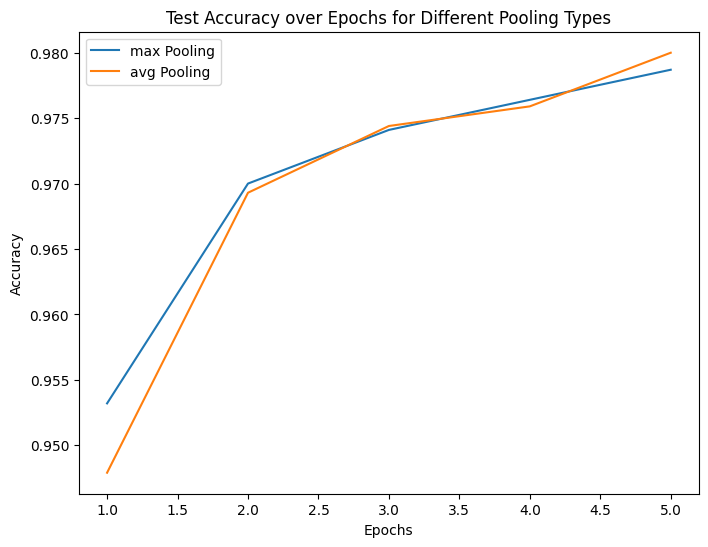

In [90]:
NUM_EPOCHS = 5
pooling_types = ['max', 'avg']

training_accuracies, test_accuracies, train_losses, test_losses = [], [], [], []

for pooling in pooling_types:
    print(f"\nTraining CNN with {pooling} pooling:\n")
    cnn = PoolingCNN(pooling_type=pooling)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(cnn.parameters(), lr=0.001)
    training_accuracies_i, test_accuracies_i, train_losses_i, test_losses_i = training_loop(model=cnn, loss_fn=loss_fn, optimizer=optimizer, num_epochs=NUM_EPOCHS, learning_rate=0.001, show_plots=False)
    training_accuracies.append(training_accuracies_i)
    test_accuracies.append(test_accuracies_i)
    train_losses.append(train_losses_i)
    test_losses.append(test_losses_i)

# Plotting one accuracy plot
fig, axs = plt.subplots(1, 1, figsize=(8, 6))
for i in range(len(pooling_types)):
    axs.plot(range(1, NUM_EPOCHS + 1), test_accuracies[i], label=f"{pooling_types[i]} Pooling")
axs.set_title("Test Accuracy over Epochs for Different Pooling Types")
axs.set_xlabel("Epochs")
axs.set_ylabel("Accuracy")
axs.legend()

### Stride and Padding

In [91]:
class VariableStrideAndPaddingCNN(nn.Module):
    def __init__(self, stride=1, padding=0):
        super().__init__()
        # Convolutional layers with stride for downsampling
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=stride, padding=padding)

        # Fully connected layers dimension based on num_layers
        dimension = ((28 + 2 * padding - 3) // stride + 1) ** 2 * 16
        print("Dimension: ", dimension)
        self.fc1 = nn.Linear(dimension, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))

        # Flatten
        x = x.view(x.size(0), -1)   # (batch, 1568)

        # Fully connected layers
        x = self.fc1(x)

        return x


Training CNN with stride 1 and padding 1:

Dimension:  12544
Epoch 1 done. Average train loss = 0.29, average train accuracy = 91.540%
Epoch 1 done. Average test loss = 0.14, average test accuracy = 95.720%
Epoch 2 done. Average train loss = 0.11, average train accuracy = 96.883%
Epoch 2 done. Average test loss = 0.09, average test accuracy = 97.270%
Epoch 3 done. Average train loss = 0.08, average train accuracy = 97.863%
Epoch 3 done. Average test loss = 0.08, average test accuracy = 97.320%
Epoch 4 done. Average train loss = 0.06, average train accuracy = 98.222%
Epoch 4 done. Average test loss = 0.08, average test accuracy = 97.620%
Epoch 5 done. Average train loss = 0.05, average train accuracy = 98.530%
Epoch 5 done. Average test loss = 0.07, average test accuracy = 97.920%

Training CNN with stride 2 and padding 1:

Dimension:  3136
Epoch 1 done. Average train loss = 0.38, average train accuracy = 89.317%
Epoch 1 done. Average test loss = 0.19, average test accuracy = 94.340%
E

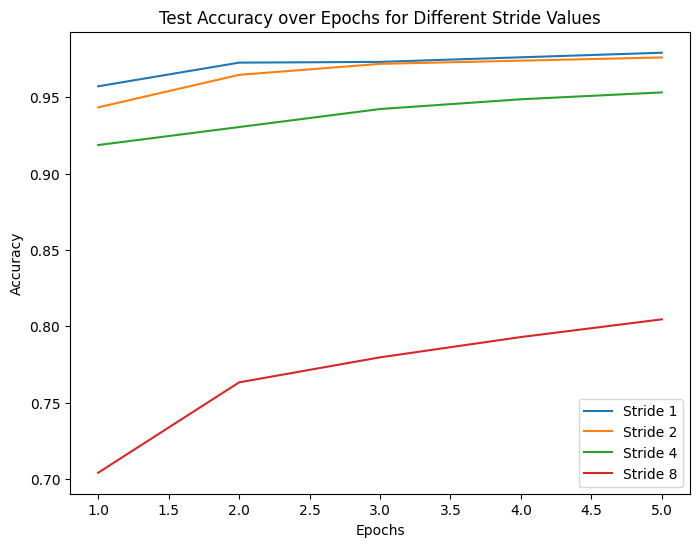

In [92]:
NUM_EPOCHS = 5
STRIDE_OPTIONS = [1, 2, 4, 8]

training_accuracies, test_accuracies, train_losses, test_losses = [], [], [], []

for stride in STRIDE_OPTIONS:
    padding = 1
    print(f"\nTraining CNN with stride {stride} and padding {padding}:\n")
    cnn = VariableStrideAndPaddingCNN(stride=stride, padding=padding)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(cnn.parameters(), lr=0.001)
    training_accuracies_i, test_accuracies_i, train_losses_i, test_losses_i = training_loop(model=cnn, loss_fn=loss_fn, optimizer=optimizer, num_epochs=NUM_EPOCHS, learning_rate=0.001, show_plots=False)
    training_accuracies.append(training_accuracies_i)
    test_accuracies.append(test_accuracies_i)
    train_losses.append(train_losses_i)
    test_losses.append(test_losses_i)

#Plotting one accuracy plot
fig, axs = plt.subplots(1, 1, figsize=(8, 6))
for i in range(len(STRIDE_OPTIONS)):
    axs.plot(range(1, NUM_EPOCHS + 1), test_accuracies[i], label=f"Stride {STRIDE_OPTIONS[i]}")
axs.set_title("Test Accuracy over Epochs for Different Stride Values")
axs.set_xlabel("Epochs")
axs.set_ylabel("Accuracy")
axs.legend()


Training CNN with padding 0 and stride 1:

Dimension:  10816
Epoch 1 done. Average train loss = 0.25, average train accuracy = 92.708%
Epoch 1 done. Average test loss = 0.11, average test accuracy = 97.030%
Epoch 2 done. Average train loss = 0.09, average train accuracy = 97.415%
Epoch 2 done. Average test loss = 0.08, average test accuracy = 97.590%
Epoch 3 done. Average train loss = 0.06, average train accuracy = 98.170%
Epoch 3 done. Average test loss = 0.07, average test accuracy = 97.910%
Epoch 4 done. Average train loss = 0.05, average train accuracy = 98.570%
Epoch 4 done. Average test loss = 0.07, average test accuracy = 97.840%
Epoch 5 done. Average train loss = 0.04, average train accuracy = 98.830%
Epoch 5 done. Average test loss = 0.07, average test accuracy = 97.770%

Training CNN with padding 1 and stride 1:

Dimension:  12544
Epoch 1 done. Average train loss = 0.28, average train accuracy = 91.998%
Epoch 1 done. Average test loss = 0.11, average test accuracy = 96.840%


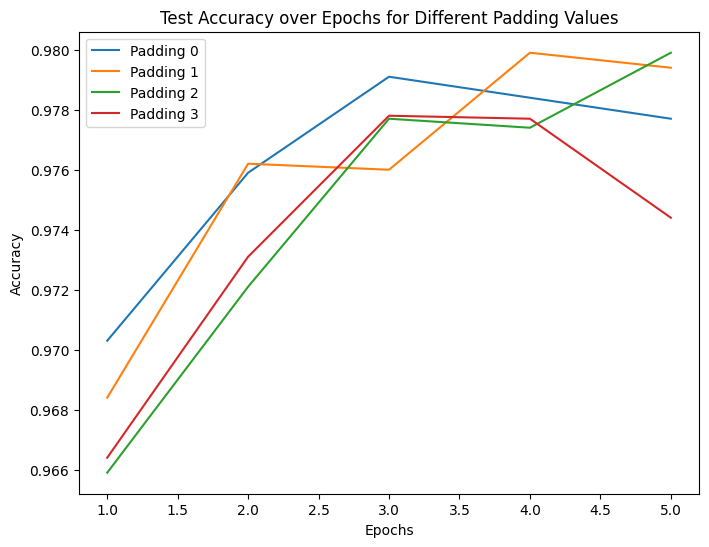

In [93]:
PADDING_OPTIONS = [0, 1, 2, 3]
training_accuracies, test_accuracies, train_losses, test_losses = [], [], [], []
for padding in PADDING_OPTIONS:
    stride = 1  # Keep stride constant
    print(f"\nTraining CNN with padding {padding} and stride {stride}:\n")
    cnn = VariableStrideAndPaddingCNN(stride=stride, padding=padding)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(cnn.parameters(), lr=0.001)
    training_accuracies_i, test_accuracies_i, train_losses_i, test_losses_i = training_loop(model=cnn, loss_fn=loss_fn, optimizer=optimizer, num_epochs=NUM_EPOCHS, learning_rate=0.001, show_plots=False)
    training_accuracies.append(training_accuracies_i)
    test_accuracies.append(test_accuracies_i)
    train_losses.append(train_losses_i)
    test_losses.append(test_losses_i)

# Plotting one accuracy plot
fig, axs = plt.subplots(1, 1, figsize=(8, 6))
for i in range(len(PADDING_OPTIONS)):
    axs.plot(range(1, NUM_EPOCHS + 1), test_accuracies[i], label=f"Padding {PADDING_OPTIONS[i]}")
axs.set_title("Test Accuracy over Epochs for Different Padding Values")
axs.set_xlabel("Epochs")
axs.set_ylabel("Accuracy")
axs.legend()

### Dialation

In [109]:
class VariableDialationCNN(nn.Module):
    def __init__(self, dilation=1):
        super().__init__()
        # Convolutional layers with stride for downsampling
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, dilation=dilation, padding=dilation)

        # Fully connected layers dimension based on num_layers
        dimension = ((28 + 2 * dilation - dilation * (3 - 1) - 1) // 1 + 1) ** 2 * 16
        print("Dimension: ", dimension)
        self.fc1 = nn.Linear(dimension, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))

        # Flatten
        x = x.view(x.size(0), -1)   # (batch, 1568)

        # Fully connected layers
        x = self.fc1(x)

        return x


Training CNN with dilation 1:

Dimension:  12544
Epoch 1 done. Average train loss = 0.38, average train accuracy = 89.838%
Epoch 1 done. Average test loss = 0.17, average test accuracy = 95.420%
Epoch 2 done. Average train loss = 0.15, average train accuracy = 96.097%
Epoch 2 done. Average test loss = 0.11, average test accuracy = 96.800%
Epoch 3 done. Average train loss = 0.10, average train accuracy = 97.442%
Epoch 3 done. Average test loss = 0.08, average test accuracy = 97.420%
Epoch 4 done. Average train loss = 0.08, average train accuracy = 97.870%
Epoch 4 done. Average test loss = 0.08, average test accuracy = 97.450%
Epoch 5 done. Average train loss = 0.06, average train accuracy = 98.278%
Epoch 5 done. Average test loss = 0.07, average test accuracy = 97.940%

Training CNN with dilation 2:

Dimension:  12544
Epoch 1 done. Average train loss = 0.39, average train accuracy = 88.892%
Epoch 1 done. Average test loss = 0.17, average test accuracy = 94.790%
Epoch 2 done. Average tr

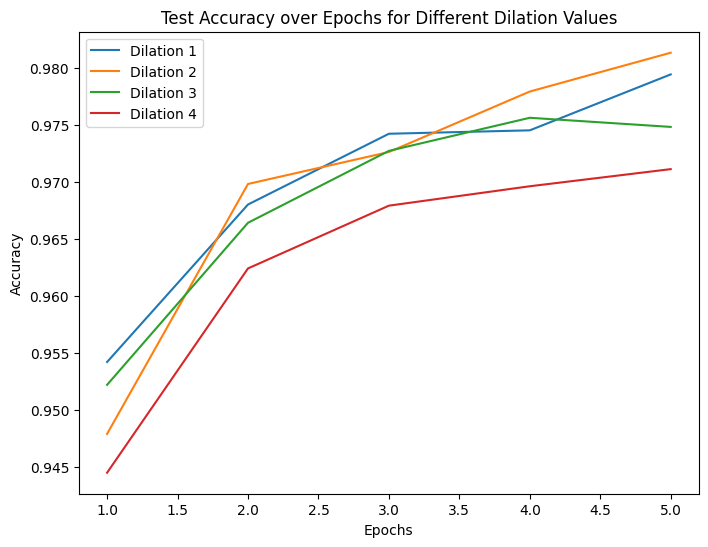

In [110]:
EPOCHS = 5
Dilation_Options = [1, 2, 3, 4]
training_accuracies, test_accuracies, train_losses, test_losses = [], [], [], []
for dilation in Dilation_Options:
    print(f"\nTraining CNN with dilation {dilation}:\n")
    cnn = VariableDialationCNN(dilation=dilation)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(cnn.parameters(), lr=0.001)
    training_accuracies_i, test_accuracies_i, train_losses_i, test_losses_i = training_loop(model=cnn, loss_fn=loss_fn, optimizer=optimizer, num_epochs=EPOCHS, learning_rate=0.001, show_plots=False)
    training_accuracies.append(training_accuracies_i)
    test_accuracies.append(test_accuracies_i)
    train_losses.append(train_losses_i)
    test_losses.append(test_losses_i)

# Plotting one accuracy plot
fig, axs = plt.subplots(1, 1, figsize=(8, 6))
for i in range(len(Dilation_Options)):
    axs.plot(range(1, EPOCHS + 1), test_accuracies[i], label=f"Dilation {Dilation_Options[i]}")
axs.set_title("Test Accuracy over Epochs for Different Dilation Values")
axs.set_xlabel("Epochs")
axs.set_ylabel("Accuracy")
axs.legend()

### Kernel Size

In [94]:
class VariableKernelSizeCNN(nn.Module):
    def __init__(self, kernel_size=3):
        super().__init__()
        # Convolutional layers with stride for downsampling
        self.conv1 = nn.Conv2d(1, 16, kernel_size=kernel_size, padding=kernel_size // 2)

        # Fully connected layers dimension based on num_layers
        dimension = 28 * 28 * 16
        print("Dimension: ", dimension)
        self.fc1 = nn.Linear(dimension, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))

        # Flatten
        x = x.view(x.size(0), -1)   # (batch, 1568)

        # Fully connected layers
        x = self.fc1(x)

        return x


Training CNN with kernel size 1:

Dimension:  12544
Epoch 1 done. Average train loss = 0.45, average train accuracy = 87.150%
Epoch 1 done. Average test loss = 0.30, average test accuracy = 91.700%
Epoch 2 done. Average train loss = 0.30, average train accuracy = 91.450%
Epoch 2 done. Average test loss = 0.33, average test accuracy = 90.120%
Epoch 3 done. Average train loss = 0.28, average train accuracy = 92.135%
Epoch 3 done. Average test loss = 0.30, average test accuracy = 91.620%
Epoch 4 done. Average train loss = 0.26, average train accuracy = 92.567%
Epoch 4 done. Average test loss = 0.26, average test accuracy = 92.800%
Epoch 5 done. Average train loss = 0.25, average train accuracy = 92.893%
Epoch 5 done. Average test loss = 0.25, average test accuracy = 92.820%

Training CNN with kernel size 3:

Dimension:  12544
Epoch 1 done. Average train loss = 0.28, average train accuracy = 92.025%
Epoch 1 done. Average test loss = 0.11, average test accuracy = 96.760%
Epoch 2 done. Aver

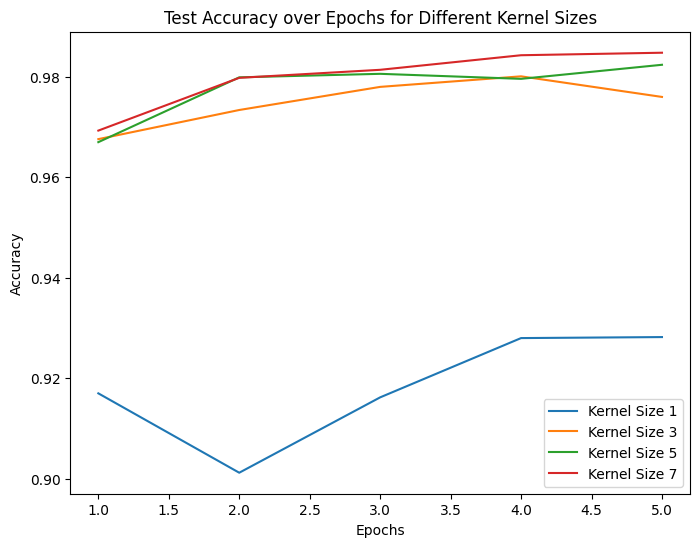

In [95]:
NUM_EPOCHS = 5
KERNAL_SIZES = [1, 3, 5, 7]

training_accuracies, test_accuracies, train_losses, test_losses = [], [], [], []

for kernel_size in KERNAL_SIZES:
    print(f"\nTraining CNN with kernel size {kernel_size}:\n")
    cnn = VariableKernelSizeCNN(kernel_size=kernel_size)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(cnn.parameters(), lr=0.001)
    training_accuracies_i, test_accuracies_i, train_losses_i, test_losses_i = training_loop(model=cnn, loss_fn=loss_fn, optimizer=optimizer, num_epochs=NUM_EPOCHS, learning_rate=0.001, show_plots=False)
    training_accuracies.append(training_accuracies_i)
    test_accuracies.append(test_accuracies_i)
    train_losses.append(train_losses_i)
    test_losses.append(test_losses_i)

# Plotting one accuracy plot
fig, axs = plt.subplots(1, 1, figsize=(8, 6))
for i in range(len(KERNAL_SIZES)):
    axs.plot(range(1, NUM_EPOCHS + 1), test_accuracies[i], label=f"Kernel Size {KERNAL_SIZES[i]}")
axs.set_title("Test Accuracy over Epochs for Different Kernel Sizes")
axs.set_xlabel("Epochs")
axs.set_ylabel("Accuracy")
axs.legend()

# Augmentation Experimentation
- Rotations
- Affine Translations
- Color Jitters


Training with rotation of 10 degrees:

Epoch 1 done. Average train loss = 0.40, average train accuracy = 88.022%
Epoch 1 done. Average test loss = 0.19, average test accuracy = 94.430%
Epoch 2 done. Average train loss = 0.17, average train accuracy = 95.260%
Epoch 2 done. Average test loss = 0.12, average test accuracy = 96.540%
Epoch 3 done. Average train loss = 0.12, average train accuracy = 96.560%
Epoch 3 done. Average test loss = 0.09, average test accuracy = 97.050%
Epoch 4 done. Average train loss = 0.10, average train accuracy = 97.187%
Epoch 4 done. Average test loss = 0.07, average test accuracy = 97.760%
Epoch 5 done. Average train loss = 0.08, average train accuracy = 97.483%
Epoch 5 done. Average test loss = 0.07, average test accuracy = 97.890%

Training with rotation of 20 degrees:

Epoch 1 done. Average train loss = 0.49, average train accuracy = 85.493%
Epoch 1 done. Average test loss = 0.18, average test accuracy = 94.920%
Epoch 2 done. Average train loss = 0.20, ave

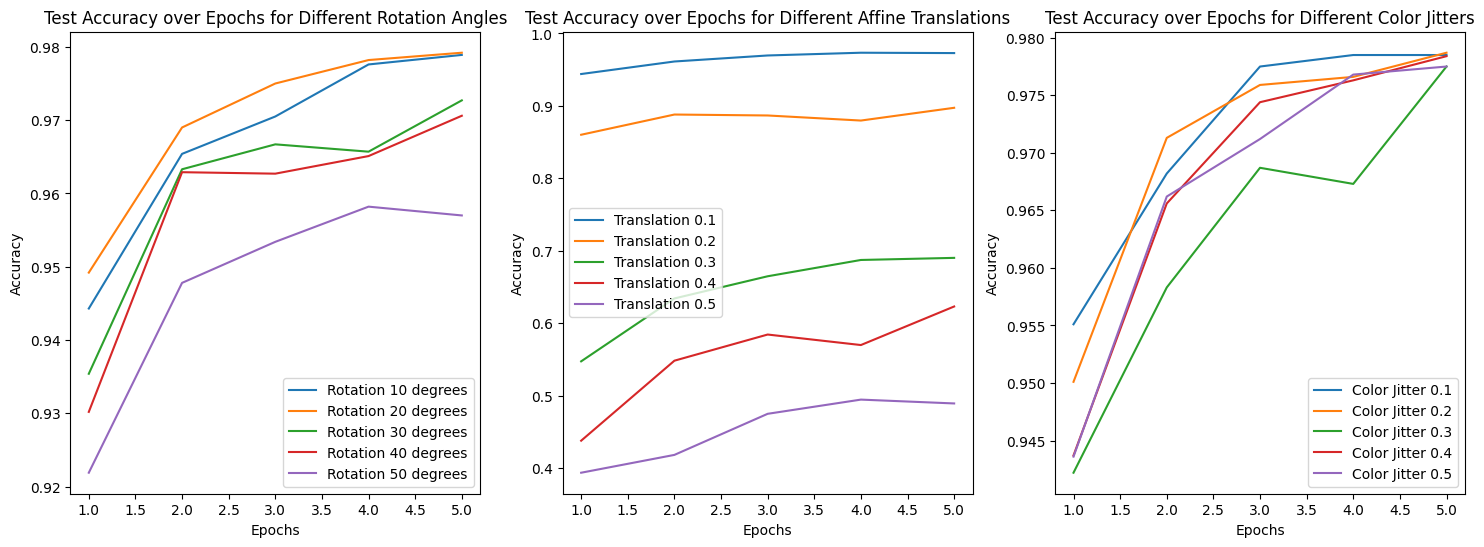

In [ ]:
Rotations = [10, 20, 30, 40, 50]
Affine_Translations = [0.1, 0.2, 0.3, 0.4, 0.5]
Color_Jitters = [0.1, 0.2, 0.3, 0.4, 0.5]
rotations_training_accuracies, rotations_test_accuracies, rotations_train_losses, rotations_test_losses = [], [], [], []

# Testing Rotations
for angle in Rotations:
    print(f"\nTraining with rotation of {angle} degrees:\n")
    train_transform = torchvision.transforms.Compose([
        torchvision.transforms.RandomRotation(degrees=angle),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=0.1307, std=0.3081)
    ])
    train_data = torchvision.datasets.MNIST('./datafiles/', train=True, download=True, transform=train_transform)
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=512, shuffle=True)

    cnn = BaselineConvNet()
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(cnn.parameters(), lr=0.001)
    rotations_training_accuracies_i, rotations_test_accuracie_i, rotations_train_losses_i, rotations_test_losses_ = training_loop(model=cnn, loss_fn=loss_fn, optimizer=optimizer, num_epochs=5, learning_rate=0.001, show_plots=False)
    rotations_training_accuracies.append(rotations_training_accuracies_i)
    rotations_test_accuracies.append(rotations_test_accuracie_i)
    rotations_train_losses.append(rotations_train_losses_i)
    rotations_test_losses.append(rotations_test_losses_)
translations_training_accuracies, translations_test_accuracies, translations_train_losses, translations_test_losses = [], [], [], []

# Testing Affine Translations
for translate in Affine_Translations:
    print(f"\nTraining with affine translation of {translate}:\n")
    train_transform = torchvision.transforms.Compose([
        torchvision.transforms.RandomAffine(degrees=0, translate=(translate, translate)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=0.1307, std=0.3081)
    ])
    train_data = torchvision.datasets.MNIST('./datafiles/', train=True, download=True, transform=train_transform)
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=512, shuffle=True)

    cnn = BaselineConvNet()
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(cnn.parameters(), lr=0.001)
    translations_training_accuracies_i, translations_test_accuracies_i, translations_train_losses_i, translations_test_losses_i = training_loop(model=cnn, loss_fn=loss_fn, optimizer=optimizer, num_epochs=5, learning_rate=0.001, show_plots=False)
    translations_training_accuracies.append(translations_training_accuracies_i)
    translations_test_accuracies.append(translations_test_accuracies_i)
    translations_train_losses.append(translations_train_losses_i)
    translations_test_losses.append(translations_test_losses_i)
colorjitters_training_accuracies, colorjitters_test_accuracies, colorjitters_train_losses, colorjitters_test_losses = [], [], [], []

# Testing Color Jitters
for jitter in Color_Jitters:
    print(f"\nTraining with color jitter of {jitter}:\n")
    train_transform = torchvision.transforms.Compose([
        torchvision.transforms.ColorJitter(brightness=jitter, contrast=jitter, saturation=jitter, hue=jitter),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=0.1307, std=0.3081)
    ])
    train_data = torchvision.datasets.MNIST('./datafiles/', train=True, download=True, transform=train_transform)
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=512, shuffle=True)

    cnn = BaselineConvNet()
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(cnn.parameters(), lr=0.001)
    colorjitters_training_accuracies_i, colorjitters_test_accuracies_i, colorjitters_train_losses_i, colorjitters_test_losses_i = training_loop(model=cnn, loss_fn=loss_fn, optimizer=optimizer, num_epochs=5, learning_rate=0.001, show_plots=False)

    colorjitters_training_accuracies.append(colorjitters_training_accuracies_i)
    colorjitters_test_accuracies.append(colorjitters_test_accuracies_i)
    colorjitters_train_losses.append(colorjitters_train_losses_i)
    colorjitters_test_losses.append(colorjitters_test_losses_i)

#Plot results for all tests
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
# Rotations
axs[0].set_title("Test Accuracy over Epochs for Different Rotation Angles")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Accuracy")
for i in range(len(Rotations)):
    axs[0].plot(range(1, 6), rotations_test_accuracies[i], label=f"Rotation {Rotations[i]} degrees")
axs[0].legend()
# Translations
axs[1].set_title("Test Accuracy over Epochs for Different Affine Translations")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy")
for i in range(len(Affine_Translations)):
    axs[1].plot(range(1, 6), translations_test_accuracies[i], label=f"Translation {Affine_Translations[i]}")
axs[1].legend()
# Color Jitters
axs[2].set_title("Test Accuracy over Epochs for Different Color Jitters")
axs[2].set_xlabel("Epochs")
axs[2].set_ylabel("Accuracy")
for i in range(len(Color_Jitters)):
    axs[2].plot(range(1, 6), colorjitters_test_accuracies[i], label=f"Color Jitter {Color_Jitters[i]}")
axs[2].legend()
plt.show()

# Regularization Experimentation

Methods Explored:
1.   Weight Decay
2.   Dropout
3.   Batch Norm
4.   Early Stopping

### Weight Decay


Testing weight decay = 1e-05
Epoch 1 done. Average train loss = 0.42, average train accuracy = 88.280%
Epoch 1 done. Average test loss = 0.19, average test accuracy = 94.660%
Epoch 2 done. Average train loss = 0.18, average train accuracy = 95.418%
Epoch 2 done. Average test loss = 0.12, average test accuracy = 96.480%
Epoch 3 done. Average train loss = 0.12, average train accuracy = 97.047%
Epoch 3 done. Average test loss = 0.09, average test accuracy = 97.270%
Epoch 4 done. Average train loss = 0.09, average train accuracy = 97.653%
Epoch 4 done. Average test loss = 0.08, average test accuracy = 97.380%
Epoch 5 done. Average train loss = 0.08, average train accuracy = 98.013%
Epoch 5 done. Average test loss = 0.08, average test accuracy = 97.600%

Testing weight decay = 0.0001
Epoch 1 done. Average train loss = 0.42, average train accuracy = 88.588%
Epoch 1 done. Average test loss = 0.19, average test accuracy = 94.560%
Epoch 2 done. Average train loss = 0.19, average train accuracy

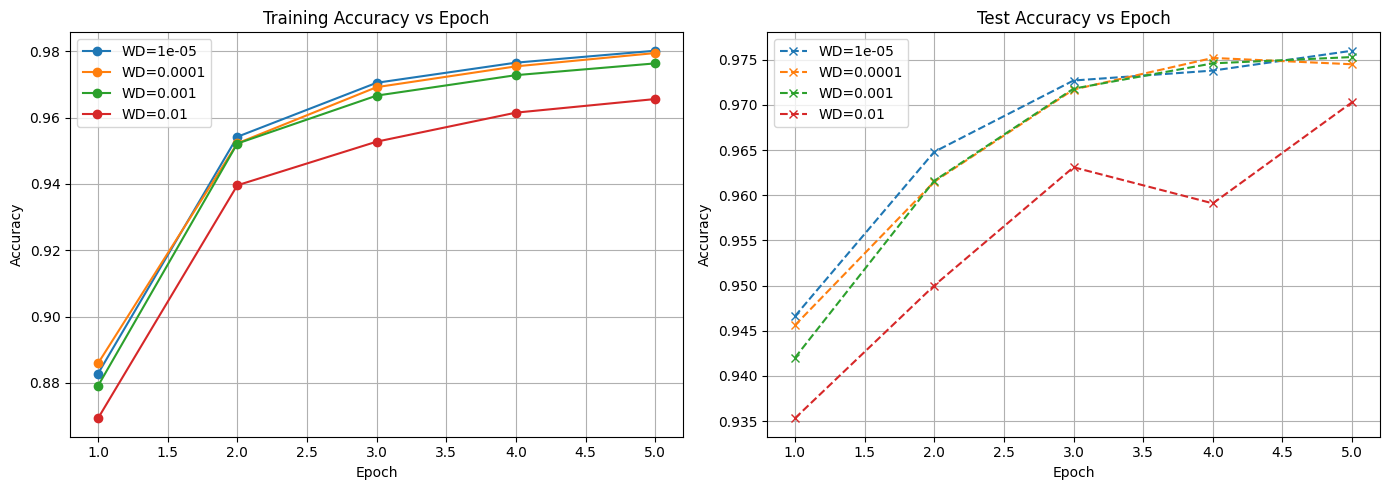

In [97]:
weight_decay_values = [1e-5, 1e-4, 1e-3, 1e-2]

# Store all epoch accuracies for plotting
all_train_accs = {}
all_test_accs = {}

for wd in weight_decay_values:
    print(f"\nTesting weight decay = {wd}")

    model = BaselineConvNet()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=wd)
    loss_fn = nn.CrossEntropyLoss()

    train_accs, test_accs, train_losses, test_losses = training_loop(
        model, loss_fn, optimizer, num_epochs=5, learning_rate=0.001, show_plots=False
    )

    all_train_accs[wd] = train_accs
    all_test_accs[wd] = test_accs

# Plot train and test accuracy separately
fig, axs = plt.subplots(1, 2, figsize=(14,5))

# Training accuracy
for wd in weight_decay_values:
    axs[0].plot(range(1, len(all_train_accs[wd])+1), all_train_accs[wd], marker='o', label=f'WD={wd}')
axs[0].set_title("Training Accuracy vs Epoch")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Accuracy")
axs[0].legend()
axs[0].grid(True)

# Test accuracy
for wd in weight_decay_values:
    axs[1].plot(range(1, len(all_test_accs[wd])+1), all_test_accs[wd], marker='x', linestyle='--', label=f'WD={wd}')
axs[1].set_title("Test Accuracy vs Epoch")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Accuracy")
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

### Dropout


Testing dropout rate = 0.1
Epoch 1 done. Average train loss = 0.44, average train accuracy = 87.483%
Epoch 1 done. Average test loss = 0.18, average test accuracy = 94.740%
Epoch 2 done. Average train loss = 0.17, average train accuracy = 95.340%
Epoch 2 done. Average test loss = 0.12, average test accuracy = 96.650%
Epoch 3 done. Average train loss = 0.12, average train accuracy = 96.917%
Epoch 3 done. Average test loss = 0.09, average test accuracy = 97.280%
Epoch 4 done. Average train loss = 0.09, average train accuracy = 97.617%
Epoch 4 done. Average test loss = 0.07, average test accuracy = 97.740%
Epoch 5 done. Average train loss = 0.07, average train accuracy = 97.975%
Epoch 5 done. Average test loss = 0.08, average test accuracy = 97.720%

Testing dropout rate = 0.25
Epoch 1 done. Average train loss = 0.42, average train accuracy = 88.413%
Epoch 1 done. Average test loss = 0.19, average test accuracy = 94.500%
Epoch 2 done. Average train loss = 0.18, average train accuracy = 9

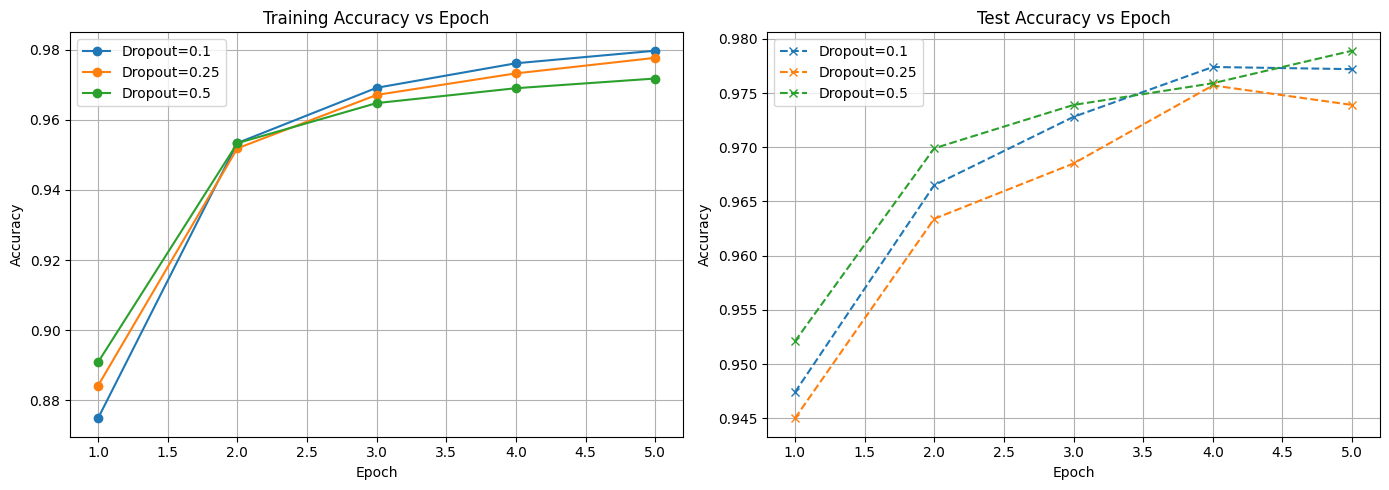

In [98]:
class DropoutConvNet(nn.Module):
    def __init__(self, dropout_rate=0.25):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(28 * 28 * 16, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc1(x)
        return x

dropout_rates = [0.1, 0.25, 0.5]

# Store all epoch accuracies
all_train_accs = {}
all_test_accs = {}

for dr in dropout_rates:
    print(f"\nTesting dropout rate = {dr}")

    model = DropoutConvNet(dropout_rate=dr)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    loss_fn = nn.CrossEntropyLoss()

    train_accs, test_accs, train_losses, test_losses = training_loop(
        model, loss_fn, optimizer, num_epochs=5, learning_rate=0.001, show_plots=False
    )

    all_train_accs[dr] = train_accs
    all_test_accs[dr] = test_accs

# Plot train and test accuracy separately
fig, axs = plt.subplots(1, 2, figsize=(14,5))

# Training accuracy
for dr in dropout_rates:
    axs[0].plot(range(1, len(all_train_accs[dr])+1), all_train_accs[dr], marker='o', label=f'Dropout={dr}')
axs[0].set_title("Training Accuracy vs Epoch")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Accuracy")
axs[0].legend()
axs[0].grid(True)

# Test accuracy
for dr in dropout_rates:
    axs[1].plot(range(1, len(all_test_accs[dr])+1), all_test_accs[dr], marker='x', linestyle='--', label=f'Dropout={dr}')
axs[1].set_title("Test Accuracy vs Epoch")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Accuracy")
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()


### Batch Norm


Testing Batch Normalization


Epoch 1 done. Average train loss = 0.37, average train accuracy = 89.302%
Epoch 1 done. Average test loss = 0.14, average test accuracy = 96.010%
Epoch 2 done. Average train loss = 0.14, average train accuracy = 96.403%
Epoch 2 done. Average test loss = 0.10, average test accuracy = 97.030%
Epoch 3 done. Average train loss = 0.10, average train accuracy = 97.450%
Epoch 3 done. Average test loss = 0.08, average test accuracy = 97.340%
Epoch 4 done. Average train loss = 0.07, average train accuracy = 98.090%
Epoch 4 done. Average test loss = 0.07, average test accuracy = 97.700%
Epoch 5 done. Average train loss = 0.06, average train accuracy = 98.425%
Epoch 5 done. Average test loss = 0.07, average test accuracy = 97.720%
Epoch 6 done. Average train loss = 0.05, average train accuracy = 98.705%
Epoch 6 done. Average test loss = 0.07, average test accuracy = 97.760%
Epoch 7 done. Average train loss = 0.04, average train accuracy = 98.828%
Epoch 7 done. Average test loss = 0.07, average te

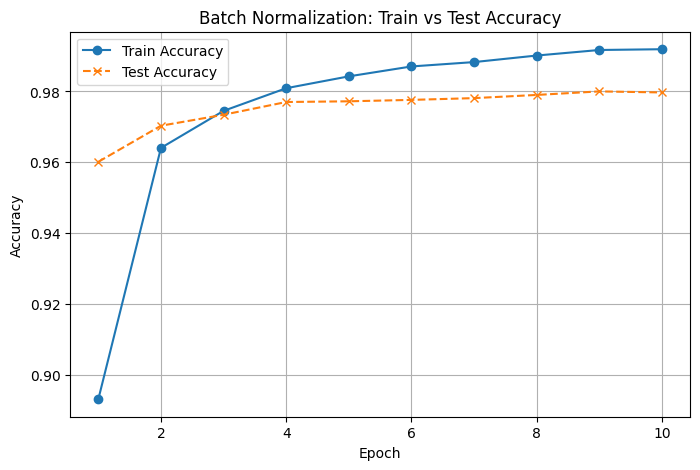

In [99]:
class BatchNormConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.fc1 = nn.Linear(28 * 28 * 16, 10)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))  # conv → batchnorm → relu
        x = x.view(x.size(0), -1)            # flatten
        x = self.fc1(x)
        return x

print("\nTesting Batch Normalization")

model = BatchNormConvNet()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

train_accs, test_accs, train_losses, test_losses = training_loop(
    model, loss_fn, optimizer, num_epochs=10, learning_rate=0.001, show_plots=False
)

plt.figure(figsize=(8,5))

# Plot training and test accuracy
plt.plot(range(1, len(train_accs)+1), train_accs, marker='o', label='Train Accuracy')
plt.plot(range(1, len(test_accs)+1), test_accs, marker='x', linestyle='--', label='Test Accuracy')

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Batch Normalization: Train vs Test Accuracy")
plt.legend()
plt.grid(True)
plt.show()

### Early Stopping

In [100]:
def training_loop_early_stopping(model, loss_fn, optimizer, num_epochs=10, patience=3, show_plots=True):
    train_accuracies, test_accuracies, train_losses, test_losses = [], [], [], []
    best_test_loss = float('inf')
    best_model_state = None
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        train_acc, train_loss = train(model, train_loader, loss_fn, optimizer, epoch)
        test_acc, test_loss = test(model, test_loader, loss_fn, epoch)

        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)
        train_losses.append(train_loss)
        test_losses.append(test_loss)

        # Early stopping logic
        if test_loss < best_test_loss:
            best_test_loss = test_loss
            best_model_state = model.state_dict().copy()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f"\nEarly stopping triggered at epoch {epoch + 1}")
            break

    # Restore best model
    if best_model_state:
        model.load_state_dict(best_model_state)

    if show_plots:
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(train_losses, label="Train Loss")
        plt.plot(test_losses, label="Test Loss")
        plt.legend()
        plt.title("Loss over Epochs")

        plt.subplot(1, 2, 2)
        plt.plot(train_accuracies, label="Train Acc")
        plt.plot(test_accuracies, label="Test Acc")
        plt.legend()
        plt.title("Accuracy over Epochs")

        plt.show()
        plt.close()

    return train_accuracies, test_accuracies, train_losses, test_losses

# Define patience values to test
patience_values = [2, 3]

results = []

for patience in patience_values:
    print(f"\nTesting Early Stopping with patience = {patience}")

    model = BaselineConvNet()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    loss_fn = nn.CrossEntropyLoss()

    train_accs, test_accs, train_losses, test_losses = training_loop_early_stopping(
        model, loss_fn, optimizer, num_epochs=10, patience=patience, show_plots=False
    )

    final_test_acc = test_accs[-1]
    total_epochs = len(train_accs)

    results.append((patience, total_epochs, final_test_acc))
    print(f"Patience: {patience}, Stopped after {total_epochs} epochs, Final Test Accuracy: {final_test_acc*100:.2f}%")


Testing Early Stopping with patience = 2
Epoch 1 done. Average train loss = 0.41, average train accuracy = 88.955%
Epoch 1 done. Average test loss = 0.20, average test accuracy = 94.350%
Epoch 2 done. Average train loss = 0.19, average train accuracy = 95.183%
Epoch 2 done. Average test loss = 0.14, average test accuracy = 96.150%
Epoch 3 done. Average train loss = 0.13, average train accuracy = 96.578%
Epoch 3 done. Average test loss = 0.11, average test accuracy = 96.840%
Epoch 4 done. Average train loss = 0.10, average train accuracy = 97.330%
Epoch 4 done. Average test loss = 0.08, average test accuracy = 97.380%
Epoch 5 done. Average train loss = 0.08, average train accuracy = 97.837%
Epoch 5 done. Average test loss = 0.07, average test accuracy = 97.540%
Epoch 6 done. Average train loss = 0.07, average train accuracy = 98.135%
Epoch 6 done. Average test loss = 0.07, average test accuracy = 97.690%
Epoch 7 done. Average train loss = 0.06, average train accuracy = 98.370%
Epoch 7 